# Intro

* From a given data-set, extract a predictor from data
* Dataset used: Boston Housing markets available at UCI machine learning repository
* Reference: Data Driven Science and Engineering Book , by Kutz and Brunton

# Context

Given a system behavior in the form of 

$ Ax = b$,

the goal is derive from observations the coefficients of $x$ that will dictate te weights of each input with respect to the output.

The modeling assumption here is that a given number of measured atributes, such as crime rate, property tax-rate, etc., influence in house pricing per region.

## Opening the data set

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t

df = pd.read_csv('housing.data', delim_whitespace=True, header=None)

df.head()

C:\Users\felip\AppData\Local\Temp\ipykernel_24612\1909109818.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('housing.data', delim_whitespace=True, header=None)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [37]:
prices = np.array(df[13])
attributes = df.iloc[:, 0:13].values

print(prices.shape)
print(attributes.shape)

(506,)
(506, 13)


In [40]:
#changing nomenclature for clarification (Ax = b)

b = prices
A = attributes

#Paddings accounts for interception (possibility of a nonzero constant)
A = np.pad(A,[(0,0),(0,1)],mode='constant',constant_values=1)
print(A)

[[6.3200e-03 1.8000e+01 2.3100e+00 ... 3.9690e+02 4.9800e+00 1.0000e+00]
 [2.7310e-02 0.0000e+00 7.0700e+00 ... 3.9690e+02 9.1400e+00 1.0000e+00]
 [2.7290e-02 0.0000e+00 7.0700e+00 ... 3.9283e+02 4.0300e+00 1.0000e+00]
 ...
 [6.0760e-02 0.0000e+00 1.1930e+01 ... 3.9690e+02 5.6400e+00 1.0000e+00]
 [1.0959e-01 0.0000e+00 1.1930e+01 ... 3.9345e+02 6.4800e+00 1.0000e+00]
 [4.7410e-02 0.0000e+00 1.1930e+01 ... 3.9690e+02 7.8800e+00 1.0000e+00]]


# SVD

* Using SVD to estimate the values of x out of the sample dataset
* Confidence interval is computed following:
    *  $ upper = mean(x) + 1.96*\sigma/\sqrt(N) $
    * $ lower = mean(x) - 1.96*\sigma/\sqrt(N) $

where $\sigma$ is the estimated signal standard deviation and $N$ is the total number of samples

In [ ]:
#Perform SVD
U, S, VT = np.linalg.svd(A,full_matrices=0)

#Perfom regression of pseudo inverse of A using SVD components
p_inv_A = VT.T @ np.linalg.inv(np.diag(S)) @ U.T 

#Regression Ax = b -> x = inv(A) * B, where inv(A) is based on SVD above
x = p_inv_A @ b




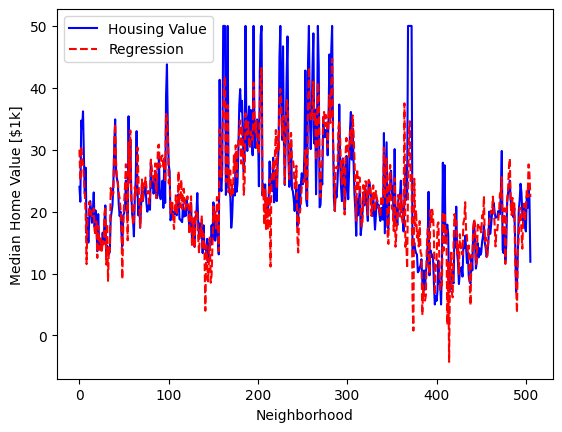

In [72]:
plt.plot(b, color='blue', label='Housing Value') # True relationship
plt.plot(A@x, '--', color='r', label='Regression')
plt.xlabel('Neighborhood')
plt.ylabel('Median Home Value [$1k]')
plt.legend()

## Confidence Interval Estimation

The confidence interval estimation is perhaps one of the most difficult concepts to tackle. It refers on how good our fitted model is while predicting our output with respect to its true measurement. 

Essentially, it has to do on how good the coefficients $x$ from $Ax = b$ are derived from the data-set used to model $inv(A)$. The technique of SVD is thus used to not only perform the pseudo inverse of $A$, such as $ x = inv(A)b$, but also to break $A$ into three manageable components in order to estimate the confidence interval.

The analogy is very simple. Considering a data-set obtained from several measurement scenarios, how good is the fit compared to the "true fit" of the experiment? Here, the "true fit" would mean the *exact* coefficients $x$ in the estimation if we had infinite time and also infinite memory storage, so we could perform infinite measurements from the experiment in order to trully obtain the data-set. It is like extending the rows of $A$ up to infinity.

In other words, it is like truncating a Fourier Series representing a signal in time. Because our computers neither have infinite memory, neither we have infinite time available to us, the Fourier Series of a given periodic signal will always have an error w.r.t to its true coefficients. Therefore, the confidence interval is used to compute trully a **zone of possible scenarios our output can fall based on the intrinsic errors of estimation associated**.


In [82]:
#Compute Root mean square error

rmse = np.sqrt(np.mean((b-A@x)**2))
print("RMSE: " + str(rmse) + " [$1k]")

#Leverage
# Degrees of freedom
n, m = A.shape
dof = n - m
h_i = np.diag(U @ U.T)  # Leverage for each point

# Standard error and 95% CI
t_critical = t.ppf(0.975, dof)  # t-value for 95% CI
SE_pred = rmse * np.sqrt(1 + h_i)
CI = t_critical * SE_pred

RMSE: 4.679191295697281 [$1k]


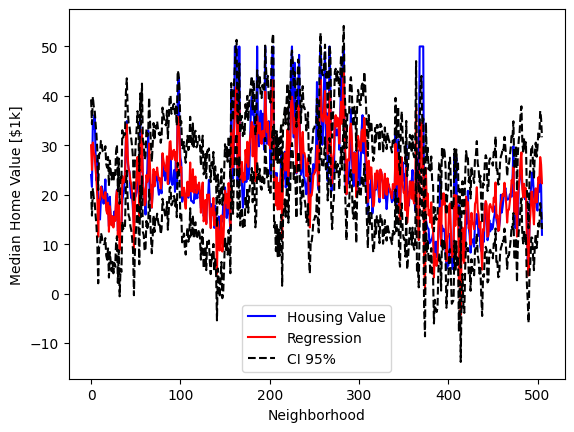

In [81]:
plt.plot(b, color='blue', label='Housing Value') # True relationship
plt.plot(A@x, '-', color='r', label='Regression')
plt.plot(A@x-CI, '--', color='black', label='CI 95%')
plt.plot(A@x+CI, '--', color='black')
plt.xlabel('Neighborhood')
plt.ylabel('Median Home Value [$1k]')
plt.legend()

# Assess the Accuracy

## $R^2$ Statistics

The $R^2$ statistic is a measure of the linear relatinship between the input and the output, when we compare the estimation performed by linear regression with respect to the original data. In this case, is when we compare our estimation $A \hat x$ with the original $b$ from the model $Ax = b$.

For multi linear regression, the $R^2$ equals $ \text Cor(Y,\hat Y)^2$, that is, the square of the correlation between the predictor's output $A \hat x$ and the original output $b$.

An $R^2$ close to 1 indicate that the model explains a large proportion of the variance in the response variable.

In [61]:
# Compute R^2 Statistics

#Calculate total sum of squares from original measurement
TSS = np.mean((b-np.mean(b))**2)*len(b)

#Calculate residual sum of squares
RSS = np.mean((b-A@x)**2)*len(b)

R2 = 1 - RSS/TSS

print("R2 Statistics coefficient: " + str(R2))



R2 Statistics coefficient: 0.7406426641094095


# Major conclusions

* SVD used as technique to ontain the pseudo-inverse matrix of A of a system model as $Ax = b$
* RMSE shows an error of aprox. $4,679.00,  